# pib_componentes


In [87]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

cwd_path = os.getcwd()
data_path = os.path.join(cwd_path, 'data')
input_path = os.path.join(data_path, 'input')
output_path = os.path.join(data_path, 'output')

In [88]:
filenames = ['consumo_privado', 'exportaciones', 'gasto_publico',
             'importaciones', 'inversiones', 'variacion']

tables_list = []
for filename in filenames:
    file_path = os.path.join(output_path, 'tables', f'{filename}.xlsx')
    df_table = pd.read_excel(file_path, names=['model', 'train_rmse', 'test_rmse'])
    df_table = df_table.sort_values('test_rmse').iloc[[0]]
    df_table['component'] = filename
    tables_list.append(df_table)

df_table = pd.concat(tables_list).set_index('component')
export_path = os.path.join(output_path, 'tables', 'champion_models.xlsx')
df_table.to_excel(export_path)


In [89]:
df_table

,model,train_rmse,test_rmse
component,,,
consumo_privado,arima,633.901721,1625.696013
exportaciones,rf,1007.028452,1575.978804
gasto_publico,ar,3070.812074,2844.398150
importaciones,rf,2332.018457,3000.897455
inversiones,lr,1276.231126,1796.857510
variacion,rf,1327.609586,3135.431326


In [90]:
input_files = {'consumo_privado': 'y_test_consumo_privado.xlsx',
         'inversiones': 'y_test_inversiones.xlsx',
          'gasto_publico': 'y_test_gasto_publico.xlsx',
         'exportaciones': 'y_test_exportaciones.xlsx',
         'importaciones': 'y_test_importaciones.xlsx',
         'variacion' : 'y_test_variacion.xlsx'}

input_list = []
for name, filename in input_files.items():
    file_path = os.path.join(output_path, 'predictions', filename)
    df_input = pd.read_excel(file_path)
    df_input.rename(columns={'y_pred': name}, inplace=True)
    df_input.set_index('fa', inplace=True)
    df_input.index = (df_input.index + pd.DateOffset(months=3)).to_period('M').to_timestamp('M')
    input_list.append(df_input)

df_components = pd.concat(input_list, axis=1, join='outer')
df_components

file_path = os.path.join(input_path, 'sector_real', 'pib', 'pib.csv')
df_pib = pd.read_csv(file_path, sep=',')
df_pib.rename(columns={'Fecha': 'fa', 'Valor': 'pib'}, inplace=True)
df_pib['fa'] = pd.to_datetime(df_pib.fa, dayfirst=True)
df_pib.set_index('fa', inplace=True)

df = df_components.merge(df_pib, how='left', left_index=True, right_index=True)
df['pib_calc'] = (df.consumo_privado + df.inversiones + df.gasto_publico
                       + df.exportaciones - df.importaciones + df.variacion
                       )
df['pib_dif'] = df.pib - df.pib_calc
df['pib_per_dif'] = 100*df['pib_dif']/df.pib
df["pib_pct_change"] = df["pib"].pct_change() * 100
df["pib_pct_change"] = df["pib_pct_change"].mask(df["pib"].isna())
df["pib_calc_pct_change"] = df["pib_calc"].pct_change() * 100

export_path = os.path.join(output_path, 'tables', 'pib_componentes.xlsx')
df.to_excel(export_path)

/var/folders/36/qrrlzn3d1191p9d_s5ryyj080000gn/T/ipykernel_2347/2037381398.py:32: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["pib_pct_change"] = df["pib"].pct_change() * 100


In [91]:
df

,consumo_privado,inversiones,gasto_publico,exportaciones,importaciones,variacion,pib,pib_calc,pib_dif,pib_per_dif,pib_pct_change,pib_calc_pct_change
fa,,,,,,,,,,,,
2023-03-31,25702.969474,32167.424142,171308.148205,34910.723780,64375.916249,-357.862535,200812.40,199355.486818,1456.913182,0.725510,NaN,NaN
2023-06-30,19718.335150,33733.855650,176943.692086,34910.723780,63688.418891,1435.407809,200847.42,203053.595582,-2206.175582,-1.098434,0.017439,1.855032
2023-09-30,21422.621090,34138.587662,179025.664506,34910.723780,63444.103971,-511.597407,203697.61,205541.895660,-1844.285660,-0.905404,1.419082,1.225440
2023-12-31,24317.847687,34506.756136,182139.082548,34552.305133,63983.683221,-766.228246,212696.62,210766.080037,1930.539963,0.907650,4.417828,2.541664
2024-03-31,27871.162163,34933.823890,185382.236721,34456.682849,64257.570962,527.904103,215046.12,218914.238763,-3868.118763,-1.798739,1.104625,3.865973
2024-06-30,21531.944511,35596.148546,187550.625266,34456.682849,63262.372024,581.836898,214009.32,216454.866047,-2445.546047,-1.142729,-0.482129,-1.123441
2024-09-30,23172.106379,35879.019726,188801.853815,34456.682849,63036.080691,686.331937,NaN,219959.914016,NaN,NaN,NaN,1.619297


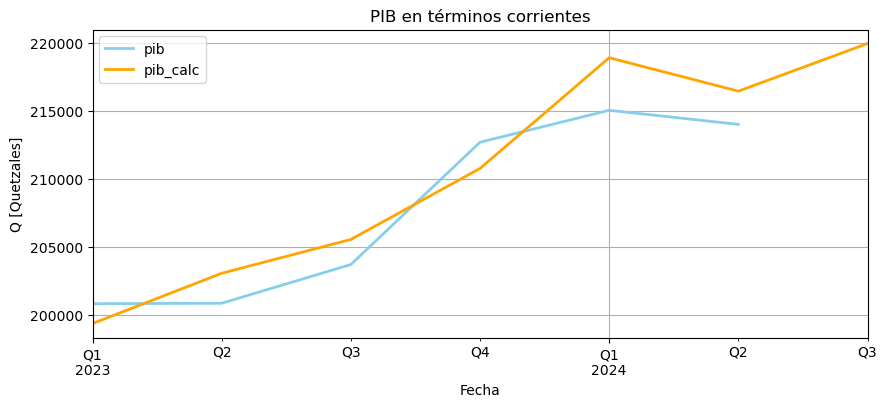

In [92]:
ax = df[['pib', 'pib_calc']].plot(
    grid=True,
    color=['skyblue', 'orange'],
    linewidth=2, 
    figsize=(10, 4),
    title='PIB en términos corrientes',
    xlabel='Fecha', 
    ylabel='Q [Quetzales]'
)

export_path = os.path.join(output_path, 'figures', 'pib_componentes.png')
plt.savefig(export_path, dpi=300, bbox_inches='tight')
plt.show()

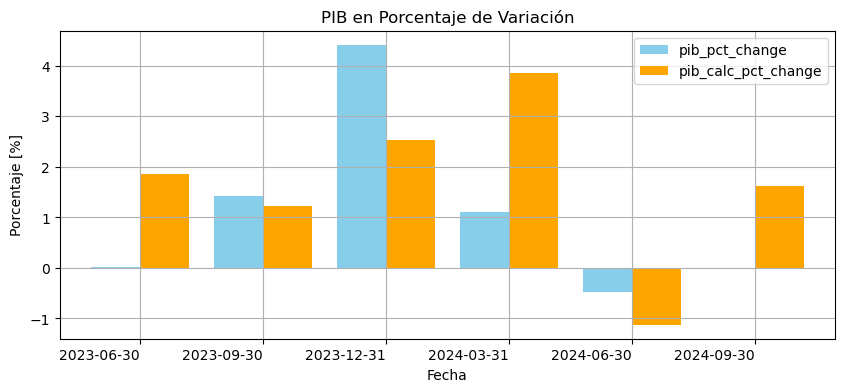

In [93]:
df_filtered = df.dropna(subset=['pib_pct_change', 'pib_calc_pct_change'], how='all')

ax = df_filtered[['pib_pct_change', 'pib_calc_pct_change']].plot(
    kind='bar',
    figsize=(10, 4),
    grid=True,
    color=['skyblue', 'orange'],
    title='PIB en Porcentaje de Variación',
    xlabel='Fecha',
    ylabel='Porcentaje [%]',
    width=0.8
)

ax.set_xticks(range(len(df_filtered.index)))
ax.set_xticklabels(df_filtered.index.strftime('%Y-%m-%d'), rotation=0, ha='right')

export_path = os.path.join(output_path, 'figures', 'pib_var_componentes.png')
plt.savefig(export_path, dpi=300, bbox_inches='tight')
plt.show()